In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings('ignore')

# Import and Clean the Data

In [3]:
column_names = {'B01001_001E' : 'population',
                'B19013_001E' : 'med_income',
                'B25077_001E' : 'med_home_value',
                'B03002_003E' : 'white',
                'B03002_004E' : 'black',
                'B02001_004E' : 'indians',
                'B03002_006E' : 'asians',
                'B03002_007E' : 'hawaiians',
                'B03002_008E' : 'non_hispanic_others',
                'B03002_009E' : 'multi_racials',
                'B03002_012E' : 'hispanics',
                'B15002_032E' : 'male_degrees',
                'B15002_015E' : 'female_degrees'}

__Test 1: does the tract qualify for gentrification?__

- The tract had a population of at least 500 residents at the beginning and end of a decade and was located within a central city
- The tract’s median household income was in the bottom 40th percentile when compared to all tracts within its metro area at the beginning of the decade
- The tract’s median home value was in the bottom 40th percentile when compared to all tracts within its metro area at the beginning of the decade

__Test 2: has it gentrified?__

- An increase in a tract's educational attainment, as measured by the percentage of residents age 25 and over holding bachelor’s degrees, was in the top third percentile of all tracts within a metro area
- A tract’s median home value increased when adjusted for inflation
- The percentage increase in a tract’s inflation-adjusted median home value was in the top third percentile of all tracts within a metro area

In [4]:
df2009 = pd.read_csv('mycensus_2009.csv').rename(columns=column_names)
df2009 = df2009.set_index('geoid')

df2018 = pd.read_csv('mycensus_2018.csv').rename(columns=column_names)
df2018 = df2018.set_index('geoid')

Drop tracts with less than 500 inhabitants:

In [5]:
df2009 = df2009.sort_values(by='population', ascending=False)[df2009['population'] >= 500]
df2018 = df2018.sort_values(by='population', ascending=False)[df2018['population'] >= 500]

Reduce dimensionality by leaving only three major racial groups:

In [6]:
df2009 = df2009.drop(columns=['year', 'indians', 'asians', 'hawaiians', 'non_hispanic_others', 'multi_racials', 'state', 'county', 'tract'])
df2018 = df2018.drop(columns=['year', 'indians', 'asians', 'hawaiians', 'non_hispanic_others', 'multi_racials', 'state', 'county', 'tract'])

Ignore tracts that have negative median household income or negative median home value: 

In [7]:
df2009 = df2009[df2009['med_income'] > 0]
df2018 = df2018[df2018['med_income'] > 0]

df2009 = df2009[df2009['med_home_value'] > 0]
df2018 = df2018[df2018['med_home_value'] > 0]

In [8]:
df2009.shape, df2018.shape

((4373, 9), (4404, 9))

Combine data on people with at least bachelor degrees into a single variable:

In [9]:
df2009['edu_att'] = 100 * (df2009['male_degrees'] + df2009['female_degrees']) / df2009['population']
df2009 = df2009.drop(columns=['male_degrees', 'female_degrees'])

df2018['edu_att'] = 100 * (df2018['male_degrees'] + df2018['female_degrees']) / df2018['population']
df2018 = df2018.drop(columns=['male_degrees', 'female_degrees'])

Transform data on racial composition into percentages and drop information on total population:

In [10]:
df2009['white'] = 100 * df2009['white'] / df2009['population']
df2009['black'] = 100 * df2009['black'] / df2009['population']
df2009['hispanics'] = 100 * df2009['hispanics'] / df2009['population']
# df2009 = df2009.drop(columns=['population'])

df2018['white'] = 100 * df2018['white'] / df2018['population']
df2018['black'] = 100 * df2018['black'] / df2018['population']
df2018['hispanics'] = 100 * df2018['hispanics'] / df2018['population']
# df2018 = df2018.drop(columns=['population'])

Make sure that the number of tracts included in each dataframe is the same:

In [11]:
matched_2009 = [True if geoid_2009 in df2018.index else False for geoid_2009 in df2009.index]
df2009 = df2009[matched_2009]

In [12]:
matched_2018 = [True if geoid_2018 in df2009.index else False for geoid_2018 in df2018.index]
df2018 = df2018[matched_2018]

In [13]:
df2009.shape, df2018.shape

((3825, 8), (3825, 8))

Combine the two dataframes into one and convert variables into changes:

In [14]:
df2009 = df2009.sort_index()
df2018 = df2018.sort_index()

In [15]:
df0918 = pd.DataFrame(0, columns=['name', 'd_pop_%', 'd_medinc_%', 'd_medhomeval_%', 
                                  'd_white_pp', 'd_black_pp', 'd_hispanics_pp', 'd_eduatt_pp'], 
                      index=df2018.index)

In [16]:
df0918['name'] = df2018['NAME']
df0918['d_pop_%'] = 100 * (df2018['population'] / df2009['population'] - 1)
df0918['d_medinc_%'] = 100 * (df2018['med_income'] / df2009['med_income'] - 1)
df0918['d_medhomeval_%'] = 100 * (df2018['med_home_value'] / df2009['med_home_value'] - 1)
df0918['d_white_pp'] = df2018['white'] - df2009['white']
df0918['d_black_pp'] = df2018['black'] - df2009['black']
df0918['d_hispanics_pp'] = df2018['hispanics'] - df2009['hispanics']
df0918['d_eduatt_pp'] = df2018['edu_att'] - df2009['edu_att']

In [17]:
df0918.head()

,name,d_pop_%,d_medinc_%,d_medhomeval_%,d_white_pp,d_black_pp,d_hispanics_pp,d_eduatt_pp
geoid,,,,,,,,
34003001000,"Census Tract 10, Bergen County, New Jersey",2.454545,24.437017,-2.857143,-0.908822,-0.075946,-0.471794,4.631403
34003002100,"Census Tract 21, Bergen County, New Jersey",-24.651394,-23.780201,99.999900,-14.069795,5.657640,0.726440,-0.450873
34003002200,"Census Tract 22, Bergen County, New Jersey",4.157044,22.264130,-12.899011,-6.444664,1.020912,4.016436,13.890994
34003002300,"Census Tract 23, Bergen County, New Jersey",-5.505034,36.038018,-4.725955,-4.216798,-1.155176,4.800948,1.622442
34003003100,"Census Tract 31, Bergen County, New Jersey",5.183673,-1.500227,-13.084356,1.970968,2.686370,3.755165,1.434923


In [514]:
df0918.to_csv('change_0918.csv')

# Exploratory Data Analysis

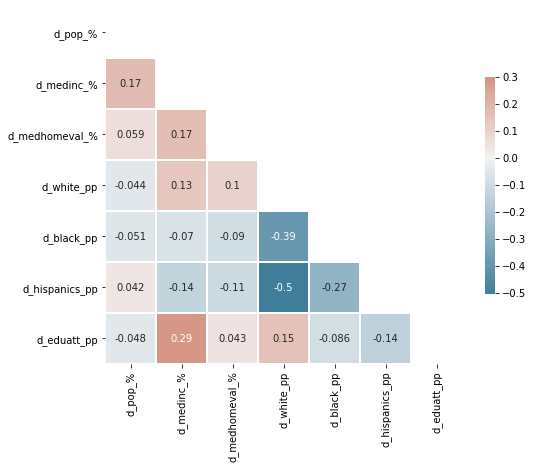

In [21]:
# Compute the correlation matrix
corr = df0918.iloc[:, 1:].corr();

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool));

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True);

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

#plt.title('Correlation Matrix for Changes over 2009-18 Period');
plt.savefig('corr_changes.png', bbox_inches='tight');

In [26]:
#sns.jointplot(x="d_eduatt_pp", y="d_medinc_%", data=df0918, kind="reg");

In [289]:
df0918.iloc[:, 2:4].corr()

,d_medinc_%,d_medhomeval_%
d_medinc_%,1.000000,0.167699
d_medhomeval_%,0.167699,1.000000


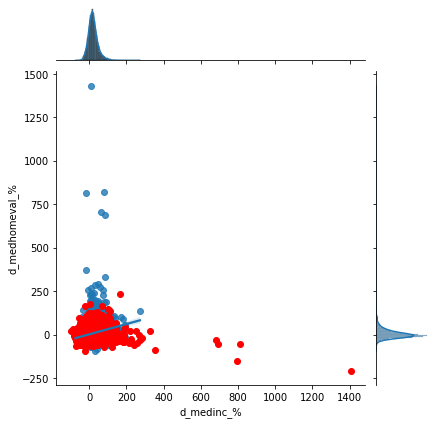

In [288]:
sns.jointplot(x="d_medinc_%", y="d_medhomeval_%", data=df0918, kind="reg");
plt.scatter(*Xt.T, label='Principal Components', color='red');

In [22]:
# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8));
# # fig.tight_layout();
# plt.subplots_adjust(right=1.3);

# # sns.distplot(df0918['d_pop_%'], ax=axes[0,0]);
# sns.distplot(df0918['d_medinc_%'], ax=axes[0,0]);
# sns.distplot(df0918['d_medhomeval_%'], ax=axes[0,1]);
# sns.distplot(df0918['d_eduatt_pp'], ax=axes[0,2]);
# sns.distplot(df0918['d_white_pp'], ax=axes[1,0]);
# sns.distplot(df0918['d_black_pp'], ax=axes[1,1]);
# sns.distplot(df0918['d_hispanics_pp'], ax=axes[1,2]);

# axes[0,0].set_ylabel(None);
# axes[0,1].set_ylabel(None);
# axes[0,2].set_ylabel(None);
# axes[1,0].set_ylabel(None);
# axes[1,1].set_ylabel(None);
# axes[1,2].set_ylabel(None);

# plt.savefig('var_densities.png');

In [669]:
from scipy.stats import normaltest
from scipy.stats import shapiro

In [670]:
alpha = 0.05

for col in df0918.columns[2:]:
    k2, p_pears = normaltest(df0918[col])
    st, p_shapiro = shapiro(df0918[col])
    if p_pears < alpha or p_shapiro < alpha:  # null hypothesis: x comes from a normal distribution
        print(f"{col} is probably not normal")
    else:
        print(f"{col} can be normal")

d_medinc_% is probably not normal
d_medhomeval_% is probably not normal
d_white_pp is probably not normal
d_black_pp is probably not normal
d_hispanics_pp is probably not normal
d_eduatt_pp is probably not normal


## Upload UCB classification for the NY tracts

In [44]:
ucb = pd.read_excel('udp_ny_final_typology_jan_2019.xlsx')
ucb = ucb.set_index('geoid')

In [45]:
df0918['ucb_type'] = [ucb.loc[geoid, 'type'] if geoid in ucb.index else 'NA' for geoid in df0918.index]

In [47]:
df0918.groupby('ucb_type')['name'].count()

ucb_type
LI - At Risk of Gentrification                         293
LI - Not Losing Low-Income Households                  388
LI - Ongoing Displacement of Low-Income Households     308
LI - Ongoing Gentrification                            201
MHI - Advanced Gentrification                          304
MHI - Ongoing Exclusion                                515
MHI - Stable Exclusion                                1572
Missing Data                                             8
NA                                                       1
VHI - Super Gentrification or Exclusion                235
Name: name, dtype: int64

In [48]:
ucb_types = list(df0918.ucb_type.unique())[:-2]
ucb_types

['VHI - Super Gentrification or Exclusion',
 'MHI - Stable Exclusion',
 'MHI - Advanced Gentrification',
 'MHI - Ongoing Exclusion',
 'LI - Not Losing Low-Income Households',
 'LI - At Risk of Gentrification',
 'LI - Ongoing Displacement of Low-Income Households',
 'LI - Ongoing Gentrification']

In [49]:
# by_type = df0918[df0918['ucb_type'] == ucb_types[7]]

# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8));
# plt.subplots_adjust(right=1.3);

# sns.distplot(df0918['d_medinc_%'], ax=axes[0,0], label='All Tracts');
# sns.distplot(df0918['d_medhomeval_%'], ax=axes[0,1], label='All Tracts');
# sns.distplot(df0918['d_eduatt_pp'], ax=axes[0,2], label='All Tracts');
# sns.distplot(df0918['d_white_pp'], ax=axes[1,0], label='All Tracts');
# sns.distplot(df0918['d_black_pp'], ax=axes[1,1], label='All Tracts');
# sns.distplot(df0918['d_hispanics_pp'], ax=axes[1,2], label='All Tracts');

# sns.distplot(by_type['d_medinc_%'], ax=axes[0,0], label='Ongoing Gentrification');
# sns.distplot(by_type['d_medhomeval_%'], ax=axes[0,1], label='Ongoing Gentrification');
# sns.distplot(by_type['d_eduatt_pp'], ax=axes[0,2], label='Ongoing Gentrification');
# sns.distplot(by_type['d_white_pp'], ax=axes[1,0], label='Ongoing Gentrification');
# sns.distplot(by_type['d_black_pp'], ax=axes[1,1], label='Ongoing Gentrification');
# sns.distplot(by_type['d_hispanics_pp'], ax=axes[1,2], label='Ongoing Gentrification');

# axes[0,0].set_ylabel(None);
# axes[0,1].set_ylabel(None);
# axes[0,2].set_ylabel(None);
# axes[1,0].set_ylabel(None);
# axes[1,1].set_ylabel(None);
# axes[1,2].set_ylabel(None);

# axes[0,0].legend();
# axes[0,1].legend();
# axes[0,2].legend();
# axes[1,0].legend();
# axes[1,1].legend();
# axes[1,2].legend();

In [245]:
elig = pd.read_csv('data_eligible_not_09_18.csv')

In [247]:
elig = elig.set_index('geoid')

In [249]:
elig = [True if geoid in elig.index else False for geoid in df0918.index]

In [250]:
elig_df = df0918[elig]

In [259]:
for col in df0918.columns[2:8]:
    st, p = ks_2samp(elig_df[col], columbia_gent[col])
    print(col, p)

d_medinc_% 6.654488071689002e-11
d_medhomeval_% 3.3306690738754696e-16
d_white_pp 0.00029465628989255865
d_black_pp 0.8036090406867095
d_hispanics_pp 0.00105874869853273
d_eduatt_pp 3.3306690738754696e-16


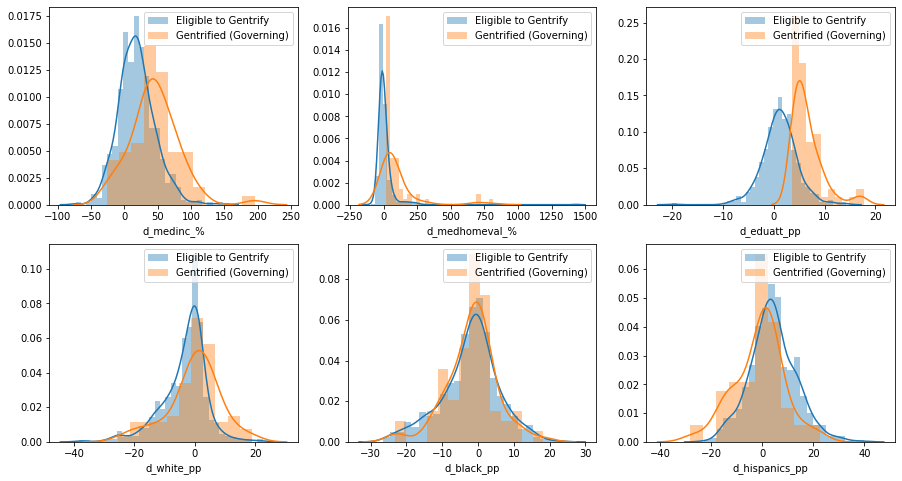

In [254]:
columbia = [True if geoid in gent_bf.index else False for geoid in df0918.index]
columbia_gent = df0918[columbia]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8));
plt.subplots_adjust(right=1.3);

sns.distplot(elig_df['d_medinc_%'], ax=axes[0,0], label='Eligible to Gentrify');
sns.distplot(elig_df['d_medhomeval_%'], ax=axes[0,1], label='Eligible to Gentrify');
sns.distplot(elig_df['d_eduatt_pp'], ax=axes[0,2], label='Eligible to Gentrify');
sns.distplot(elig_df['d_white_pp'], ax=axes[1,0], label='Eligible to Gentrify');
sns.distplot(elig_df['d_black_pp'], ax=axes[1,1], label='Eligible to Gentrify');
sns.distplot(elig_df['d_hispanics_pp'], ax=axes[1,2], label='Eligible to Gentrify');

sns.distplot(columbia_gent['d_medinc_%'], ax=axes[0,0], label='Gentrified (Governing)');
sns.distplot(columbia_gent['d_medhomeval_%'], ax=axes[0,1], label='Gentrified (Governing)');
sns.distplot(columbia_gent['d_eduatt_pp'], ax=axes[0,2], label='Gentrified (Governing)');
sns.distplot(columbia_gent['d_white_pp'], ax=axes[1,0], label='Gentrified (Governing)');
sns.distplot(columbia_gent['d_black_pp'], ax=axes[1,1], label='Gentrified (Governing)');
sns.distplot(columbia_gent['d_hispanics_pp'], ax=axes[1,2], label='Gentrified (Governing)');

axes[0,0].set_ylabel(None);
axes[0,1].set_ylabel(None);
axes[0,2].set_ylabel(None);
axes[1,0].set_ylabel(None);
axes[1,1].set_ylabel(None);
axes[1,2].set_ylabel(None);

axes[0,0].legend();
axes[0,1].legend();
axes[0,2].legend();
axes[1,0].legend();
axes[1,1].legend();
axes[1,2].legend();

In [825]:
gauss_gent.to_csv('gentrified_cluster.csv')

In [860]:
# single_clust = [True if geoid == 3 else False for geoid in clusters]
# gauss_gent = df0918[single_clust]

# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8));
# plt.subplots_adjust(right=1.3);

# sns.distplot(df0918['d_medinc_%'], ax=axes[0,0], label='All Tracts');
# sns.distplot(df0918['d_medhomeval_%'], ax=axes[0,1], label='All Tracts');
# sns.distplot(df0918['d_eduatt_pp'], ax=axes[0,2], label='All Tracts');
# sns.distplot(df0918['d_white_pp'], ax=axes[1,0], label='All Tracts');
# sns.distplot(df0918['d_black_pp'], ax=axes[1,1], label='All Tracts');
# sns.distplot(df0918['d_hispanics_pp'], ax=axes[1,2], label='All Tracts');

# sns.distplot(gauss_gent['d_medinc_%'], ax=axes[0,0], label='Cluster 4');
# sns.distplot(gauss_gent['d_medhomeval_%'], ax=axes[0,1], label='Cluster 4');
# sns.distplot(gauss_gent['d_eduatt_pp'], ax=axes[0,2], label='Cluster 4');
# sns.distplot(gauss_gent['d_white_pp'], ax=axes[1,0], label='Cluster 4');
# sns.distplot(gauss_gent['d_black_pp'], ax=axes[1,1], label='Cluster 4');
# sns.distplot(gauss_gent['d_hispanics_pp'], ax=axes[1,2], label='Cluster 4');

# axes[0,0].set_ylabel(None);
# axes[0,1].set_ylabel(None);
# axes[0,2].set_ylabel(None);
# axes[1,0].set_ylabel(None);
# axes[1,1].set_ylabel(None);
# axes[1,2].set_ylabel(None);

# axes[0,0].legend();
# axes[0,1].legend();
# axes[0,2].legend();
# axes[1,0].legend();
# axes[1,1].legend();
# axes[1,2].legend();

# plt.savefig('gaussian_cluster_gentr.png');

In [134]:
kmeans_gent.shape

(126, 9)

# Apply Unsupervized Classificators to Label Gentrified Tracts

First apply simple filter to see if there an intersection in the tail of the above distributions:

In [568]:
high_inc_prices = [df0918.loc[geoid, 'd_medinc_%'] > 50 and df0918.loc[geoid, 'd_medhomeval_%'] > 50 for geoid in df0918.index]

In [569]:
gent = df0918[high_inc_prices]

In [570]:
gent

,name,d_pop_%,d_medinc_%,d_medhomeval_%,d_white_pp,d_black_pp,d_hispanics_pp,d_eduatt_pp
geoid,,,,,,,,
34003053100,"Census Tract 531, Bergen County, New Jersey",-14.278089,56.039331,78.519821,-25.234717,4.545455,0.938061,-2.773169
36005003300,"Census Tract 33, Bronx County, New York",12.119289,67.474894,59.211891,0.980109,8.542541,-14.502861,0.012066
36047003500,"Census Tract 35, Kings County, New York",44.648318,69.352644,55.649844,23.957303,-18.513167,-1.308584,11.313853
36047003900,"Census Tract 39, Kings County, New York",14.980545,106.196477,71.536103,6.933115,-6.141819,-8.866789,4.621446
36047006000,"Census Tract 60, Kings County, New York",13.320965,98.431064,56.140051,-3.276678,-1.261596,0.620628,-1.705224
...,...,...,...,...,...,...,...,...
36081024500,"Census Tract 245, Queens County, New York",7.785179,84.820892,689.766082,-5.682226,-2.611486,1.191014,9.015975
36081025500,"Census Tract 255, Queens County, New York",-11.609337,72.526780,225.212867,-11.541722,0.000000,6.600484,3.004279
36081048900,"Census Tract 489, Queens County, New York",11.657835,53.406399,87.145867,-3.085079,0.067797,0.225766,8.966551


In [571]:
gent.shape

(85, 8)

Compare the above to the results obtained from the application of the Governing Magazine methodology:

In [40]:
gent_bf = pd.read_csv('data_gentrified_09_18.csv')
gent_bf = gent_bf.set_index('geoid')

In [771]:
sum([True for geoid in gent_bf.index if geoid in gent.index])

14

In [773]:
gent_bf['ucb_type'] = [ucb.loc[geoid, 'type'] if geoid in ucb.index else 'NA' for geoid in gent_bf.index]

In [775]:
gent_bf.ucb_type.value_counts().to_dict()

{'LI - Ongoing Displacement of Low-Income Households': 18,
 'LI - Ongoing Gentrification': 14,
 'MHI - Stable Exclusion': 12,
 'LI - Not Losing Low-Income Households': 8,
 'LI - At Risk of Gentrification': 8,
 'MHI - Ongoing Exclusion': 4,
 'MHI - Advanced Gentrification': 2}

## Apply PCA

In [264]:
from sklearn.decomposition import PCA

In [266]:
pca = PCA(n_components=2)
X = df0918.iloc[:, 2:8]
Xt = pca.fit_transform(X)

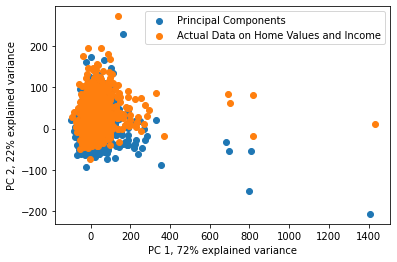

In [290]:
plt.scatter(*Xt.T, label='Principal Components');
plt.scatter(df0918['d_medhomeval_%'], df0918['d_medinc_%'], label='Actual Data on Home Values and Income');
plt.xlabel(f'PC 1, {round(100 * exp_var[0])}% explained variance');
plt.ylabel(f'PC 2, {round(100 * exp_var[1])}% explained variance');
plt.legend();

In [609]:
pca.components_

array([[ 0.13658566,  0.99010166,  0.02123916, -0.01287919, -0.01970651,
         0.00614363],
       [ 0.98740939, -0.13837328,  0.04395367, -0.0131676 , -0.037288  ,
         0.04878355]])

In [268]:
exp_var = pca.explained_variance_ratio_

The first component is essentially home value, the second is median income.

## Apply one-class SVM for novelty detection

First, scale the data:

In [578]:
from sklearn.svm import OneClassSVM

In [628]:
Xt.shape

(3825, 6)

In [613]:
oneclass_svm = OneClassSVM()

In [614]:
oneclass_svm.fit(Xt);
classif = oneclass_svm.predict(Xt);

In [615]:
novelties = [True if el == -1 else False for el in classif]
gentr_svm = df0918[novelties]

In [616]:
gentr_svm.shape

(1913, 8)

In [ ]:
for clust in range(1):
    cluster = [True if el == clust else False for el in clusters]
    gentr_gauss_mix = df0918[cluster]
    freq_distr = gentr_gauss_mix['ucb_type'].value_counts().to_dict()
    print(f'Cluster {clust + 1}. Number of tracts : {sum(cluster)}.')
    print('----------------------------------')
    for key, value in freq_distr.items():
        print(f'{key} : {value}')
    print('\n')

That's too many outliers.

## Apply Isolation Forest to detect outliers

In [74]:
from sklearn.ensemble import IsolationForest

In [80]:
cont = 150 / 3825

In [81]:
clf = IsolationForest(n_estimators=100, contamination=cont)
clf.fit(Xt)

IsolationForest(contamination=0.0392156862745098)

In [82]:
classif = clf.predict(Xt)

In [83]:
outliers = [True if el < 0 else False for el in classif]
gentr_isoforest = df0918[outliers]

In [84]:
gentr_isoforest.shape

(150, 9)

In [86]:
sum([True for geoid in gent_bf.index if geoid in gentr_isoforest.index])

19

In [90]:
gentr_isoforest.ucb_type.value_counts().to_dict()

{'LI - Ongoing Displacement of Low-Income Households': 28,
 'LI - Ongoing Gentrification': 28,
 'MHI - Stable Exclusion': 27,
 'MHI - Ongoing Exclusion': 25,
 'MHI - Advanced Gentrification': 18,
 'LI - Not Losing Low-Income Households': 13,
 'LI - At Risk of Gentrification': 9,
 'VHI - Super Gentrification or Exclusion': 1,
 'Missing Data': 1}

In [88]:
# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8));
# plt.subplots_adjust(right=1.3);

# sns.distplot(df0918['d_medinc_%'], ax=axes[0,0], label='All Tracts');
# sns.distplot(df0918['d_medhomeval_%'], ax=axes[0,1], label='All Tracts');
# sns.distplot(df0918['d_eduatt_pp'], ax=axes[0,2], label='All Tracts');
# sns.distplot(df0918['d_white_pp'], ax=axes[1,0], label='All Tracts');
# sns.distplot(df0918['d_black_pp'], ax=axes[1,1], label='All Tracts');
# sns.distplot(df0918['d_hispanics_pp'], ax=axes[1,2], label='All Tracts');

# sns.distplot(gentr_isoforest['d_medinc_%'], ax=axes[0,0], label='Isolation Forest Outliers');
# sns.distplot(gentr_isoforest['d_medhomeval_%'], ax=axes[0,1], label='Isolation Forest Outliers');
# sns.distplot(gentr_isoforest['d_eduatt_pp'], ax=axes[0,2], label='Isolation Forest Outliers');
# sns.distplot(gentr_isoforest['d_white_pp'], ax=axes[1,0], label='Isolation Forest Outliers');
# sns.distplot(gentr_isoforest['d_black_pp'], ax=axes[1,1], label='Isolation Forest Outliers');
# sns.distplot(gentr_isoforest['d_hispanics_pp'], ax=axes[1,2], label='Isolation Forest Outliers');

# axes[0,0].set_ylabel(None);
# axes[0,1].set_ylabel(None);
# axes[0,2].set_ylabel(None);
# axes[1,0].set_ylabel(None);
# axes[1,1].set_ylabel(None);
# axes[1,2].set_ylabel(None);

# axes[0,0].legend();
# axes[0,1].legend();
# axes[0,2].legend();
# axes[1,0].legend();
# axes[1,1].legend();
# axes[1,2].legend();

## Apply Gaussian Mixture Algorithm

In [692]:
from sklearn.mixture import GaussianMixture

In [742]:
gm = GaussianMixture(n_components=8, covariance_type='full')
gm.fit(Xt)
clusters = gm.predict(Xt)

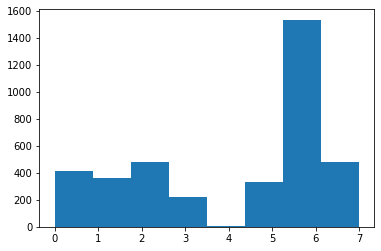

In [743]:
plt.hist(clusters, bins=8);

In [744]:
clust_1 = [True if el == 0 else False for el in clusters]
gentr_gauss_mix = df0918[clust_1]

Most frequent UCB classification for each cluster:

In [753]:
df0918['ucb_type'].value_counts().to_dict()

{'MHI - Stable Exclusion': 1572,
 'MHI - Ongoing Exclusion': 515,
 'LI - Not Losing Low-Income Households': 388,
 'LI - Ongoing Displacement of Low-Income Households': 308,
 'MHI - Advanced Gentrification': 304,
 'LI - At Risk of Gentrification': 293,
 'VHI - Super Gentrification or Exclusion': 235,
 'LI - Ongoing Gentrification': 201,
 'Missing Data': 8,
 'NA': 1}

In [762]:
freq_distr = gentr_gauss_mix['ucb_type'].value_counts().to_dict()

In [828]:
#for clust in range(0, 8):
clust = 3
cluster = [True if el == clust else False for el in clusters]
gentr_gauss_mix = df0918[cluster]
freq_distr = gentr_gauss_mix['ucb_type'].value_counts().to_dict()
# max_key = max(freq_distr, key=freq_distr.get)
# most_freq = max(list(freq_distr.values()))
# Most frequent UCB type : {max_key} ({most_freq}
print(f'Cluster {clust + 1}. Number of tracts : {sum(cluster)}.')
print('----------------------------------')
for key, value in freq_distr.items():
    print(f'{key} : {value}')
print('\n')

Cluster 4. Number of tracts : 224.
----------------------------------
MHI - Stable Exclusion : 51
LI - Ongoing Gentrification : 38
MHI - Ongoing Exclusion : 36
LI - Ongoing Displacement of Low-Income Households : 30
MHI - Advanced Gentrification : 22
LI - Not Losing Low-Income Households : 21
LI - At Risk of Gentrification : 18
VHI - Super Gentrification or Exclusion : 7
Missing Data : 1




In [829]:
#gentr_gauss_mix

In [830]:
# fig, ax = fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8));

# sns.distplot(gentr_gauss_mix['d_medinc_%'], ax=ax[0,0]);
# sns.distplot(df0918['d_medinc_%'], ax=ax[0,0]);

# sns.distplot(gentr_gauss_mix['d_medhomeval_%'], ax=ax[0,1]);
# sns.distplot(df0918['d_medhomeval_%'], ax=ax[0,1]);

# sns.distplot(gentr_gauss_mix['d_eduatt_pp'], ax=ax[1,0]);
# sns.distplot(df0918['d_eduatt_pp'], ax=ax[1,0]);

# sns.distplot(gentr_gauss_mix['d_white_pp'], ax=ax[1,1]);
# sns.distplot(df0918['d_white_pp'], ax=ax[1,1]);

## K-means clustering

In [18]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [19]:
scaler = StandardScaler()
X = df0918.iloc[:, 2:]
Xt = scaler.fit_transform(X)

In [23]:
kmeans = KMeans(n_clusters=8, max_iter=1000);
kmeans.fit(Xt);

In [24]:
kmeans_clusters = kmeans.predict(Xt)

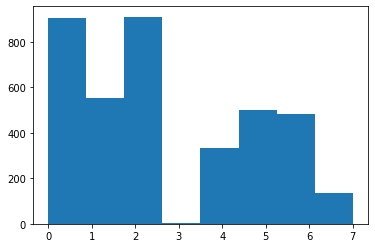

In [25]:
plt.hist(kmeans_clusters, bins=8);

In [839]:
freq_distr = gentr_gauss_mix['ucb_type'].value_counts().to_dict()
print(f'Cluster {clust + 1}. Number of tracts : {sum(cluster)}.')
for key, value in freq_distr.items():
    print(f'{key} : {value}')
print('\n')

In [26]:
single_clust = [True if geoid == 7 else False for geoid in kmeans_clusters]
kmeans_gent = df0918[single_clust]

In [65]:
gentr_ucb_types = kmeans_gent['ucb_type'].value_counts().to_dict()

In [206]:
25 + 28 + 20 + 17 + 16 

106

In [66]:
gentr_ucb_types

{'MHI - Ongoing Exclusion': 28,
 'MHI - Stable Exclusion': 25,
 'LI - Ongoing Displacement of Low-Income Households': 20,
 'LI - Ongoing Gentrification': 17,
 'MHI - Advanced Gentrification': 16,
 'LI - Not Losing Low-Income Households': 15,
 'LI - At Risk of Gentrification': 3,
 'VHI - Super Gentrification or Exclusion': 2}

In [130]:
gentr_ucb_types_df = pd.DataFrame.from_dict(gentr_ucb_types, orient='index')
gentr_ucb_types_df.columns = ['UCB Type']

In [132]:
gentr_ucb_types_df

,UCB Type
MHI - Ongoing Exclusion,28
MHI - Stable Exclusion,25
LI - Ongoing Displacement of Low-Income Households,20
LI - Ongoing Gentrification,17
MHI - Advanced Gentrification,16
LI - Not Losing Low-Income Households,15
LI - At Risk of Gentrification,3
VHI - Super Gentrification or Exclusion,2


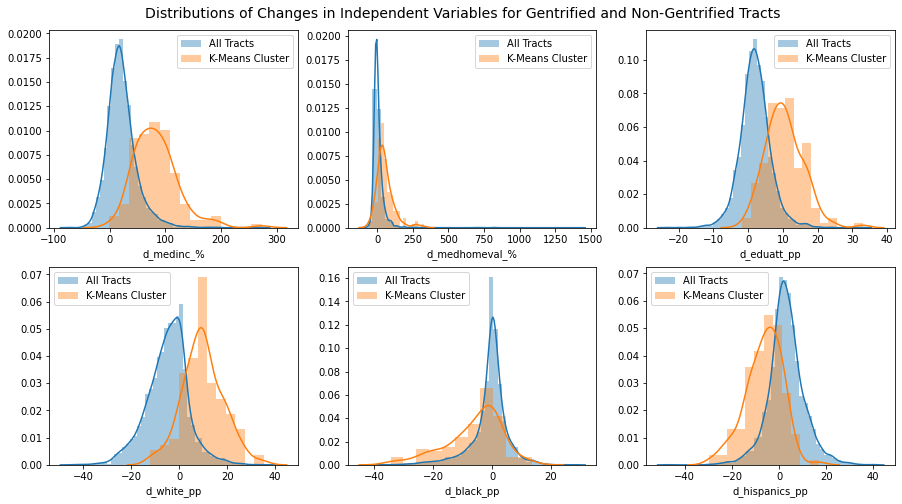

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8));
plt.subplots_adjust(right=1.3);

sns.distplot(df0918['d_medinc_%'], ax=axes[0,0], label='All Tracts');
sns.distplot(df0918['d_medhomeval_%'], ax=axes[0,1], label='All Tracts');
sns.distplot(df0918['d_eduatt_pp'], ax=axes[0,2], label='All Tracts');
sns.distplot(df0918['d_white_pp'], ax=axes[1,0], label='All Tracts');
sns.distplot(df0918['d_black_pp'], ax=axes[1,1], label='All Tracts');
sns.distplot(df0918['d_hispanics_pp'], ax=axes[1,2], label='All Tracts');

sns.distplot(kmeans_gent['d_medinc_%'], ax=axes[0,0], label='K-Means Cluster');
sns.distplot(kmeans_gent['d_medhomeval_%'], ax=axes[0,1], label='K-Means Cluster');
sns.distplot(kmeans_gent['d_eduatt_pp'], ax=axes[0,2], label='K-Means Cluster');
sns.distplot(kmeans_gent['d_white_pp'], ax=axes[1,0], label='K-Means Cluster');
sns.distplot(kmeans_gent['d_black_pp'], ax=axes[1,1], label='K-Means Cluster');
sns.distplot(kmeans_gent['d_hispanics_pp'], ax=axes[1,2], label='K-Means Cluster');

axes[0,0].set_ylabel(None);
axes[0,1].set_ylabel(None);
axes[0,2].set_ylabel(None);
axes[1,0].set_ylabel(None);
axes[1,1].set_ylabel(None);
axes[1,2].set_ylabel(None);

axes[0,0].legend();
axes[0,1].legend();
axes[0,2].legend();
axes[1,0].legend();
axes[1,1].legend();
axes[1,2].legend();

fig.suptitle('Distributions of Changes in Independent Variables for Gentrified and Non-Gentrified Tracts', x=0.7, y=0.92, fontsize=14);

In [118]:
from scipy.stats import ks_2samp

dist_stat = {}

for col in kmeans_gent.columns[2:8]:
    st, pval = ks_2samp(kmeans_gent[col], df0918[col])
    dist_stat[col] = [pval, df0918[col].mean(), kmeans_gent[col].mean(), df0918[col].std(), kmeans_gent[col].std()]

In [121]:
dist_stat_df = pd.DataFrame.from_dict(dist_stat, orient='index')
dist_stat_df = dist_stat_df.round(3)

In [127]:
cols = ['KS p-value', 'All Tracts Mean', 'Gent. Tracts Mean', 'All Tracts St. Dev.', 'Gent. Tracts St. Dev.']
dist_stat_df.columns = cols

idx = ['Change in Median Income, pct', 'Change in Median Home Value, pct', 'Change in White Pop, pp', 
       'Change in Black Pop, pp' , 'Change in Hispanic Pop, pp', 'Change in Educational Att, pp']
dist_stat_df.index = idx

In [128]:
dist_stat_df

,KS p-value,All Tracts Mean,Gent. Tracts Mean,All Tracts St. Dev.,Gent. Tracts St. Dev.
"Change in Median Income, pct",0.0,21.904,85.560,26.781,39.267
"Change in Median Home Value, pct",0.0,8.046,54.250,47.301,60.731
"Change in White Pop, pp",0.0,-4.923,9.920,8.711,8.413
"Change in Black Pop, pp",0.0,-0.792,-5.983,6.344,9.513
"Change in Hispanic Pop, pp",0.0,2.996,-7.294,7.656,8.833
"Change in Educational Att, pp",0.0,2.018,10.520,4.391,5.301


In [129]:
dist_stat_df.to_latex()

'\\begin{tabular}{lrrrrr}\n\\toprule\n{} &  KS p-value &  All Tracts Mean &  Gent. Tracts Mean &  All Tracts St. Dev. &  Gent. Tracts St. Dev. \\\\\n\\midrule\nChange in Median Income, pct     &         0.0 &           21.904 &             85.560 &               26.781 &                 39.267 \\\\\nChange in Median Home Value, pct &         0.0 &            8.046 &             54.250 &               47.301 &                 60.731 \\\\\nChange in White Pop, pp          &         0.0 &           -4.923 &              9.920 &                8.711 &                  8.413 \\\\\nChange in Black Pop, pp          &         0.0 &           -0.792 &             -5.983 &                6.344 &                  9.513 \\\\\nChange in Hispanic Pop, pp       &         0.0 &            2.996 &             -7.294 &                7.656 &                  8.833 \\\\\nChange in Educational Att, pp    &         0.0 &            2.018 &             10.520 &                4.391 &                  5.301 

In [93]:
kmeans_gent.head()

,name,d_pop_%,d_medinc_%,d_medhomeval_%,d_white_pp,d_black_pp,d_hispanics_pp,d_eduatt_pp,ucb_type
geoid,,,,,,,,,
34017001900,"Census Tract 19, Hudson County, New Jersey",-3.328982,76.930315,32.116788,0.114109,7.929289,-24.030055,17.075603,LI - Ongoing Displacement of Low-Income Househ...
34017002800,"Census Tract 28, Hudson County, New Jersey",7.973231,148.177616,10.379500,9.415334,-7.339239,-6.495796,6.968769,MHI - Ongoing Exclusion
34017003000,"Census Tract 30, Hudson County, New Jersey",-3.612424,70.021623,18.220859,9.528056,-9.569030,5.964340,5.312251,LI - At Risk of Gentrification
34017003100,"Census Tract 31, Hudson County, New Jersey",51.023940,98.021803,-17.455214,1.049043,-2.247343,-12.060648,7.199398,LI - Not Losing Low-Income Households
34017004700,"Census Tract 47, Hudson County, New Jersey",7.096028,54.304107,24.338925,12.060906,-7.292188,-12.258815,6.799698,LI - At Risk of Gentrification


In [71]:
gent_overlap = [True if geoid in gent_bf.index else False for geoid in kmeans_gent.index]
gent_overlap_df = kmeans_gent[gent_overlap]

In [73]:
gent_overlap_df.ucb_type.value_counts().to_dict()

{'LI - Ongoing Displacement of Low-Income Households': 6,
 'LI - At Risk of Gentrification': 3,
 'MHI - Stable Exclusion': 3,
 'LI - Ongoing Gentrification': 2,
 'MHI - Ongoing Exclusion': 1,
 'LI - Not Losing Low-Income Households': 1,
 'MHI - Advanced Gentrification': 1}

In [845]:
kmeans_gent.to_csv('kmeans_gentrified.csv');

## Calculate cosine similarity

In [625]:
from sklearn.metrics.pairwise import cosine_similarity

In [646]:
cos = cosine_similarity(Xt)
cos = np.tril(cos, -1)

In [647]:
cos.shape

(3825, 3825)

In [649]:
cos = pd.DataFrame(cos, columns=df0918.index, index=df0918.index)
cos = cos.rename_axis(None).rename_axis(None, axis=1)
cos = cos.stack().reset_index()
cos.columns = ['geoid_1', 'geoid_2', 'cos_sim']

In [651]:
cos = cos.sort_values(by='cos_sim', ascending=False)

In [657]:
cos.iloc[:5000, :]

,geoid_1,geoid_2,cos_sim
7945931,36047116600,36005042800,0.998762
13813139,36103190707,34035052100,0.998525
13326412,36103146703,34003048100,0.998469
11272998,36081055900,34025807400,0.998398
4674198,34039039400,34003021600,0.998322
...,...,...,...
11863167,36081104700,36047053400,0.967919
12979052,36103123202,34027043500,0.967919
13006058,36103123701,34035051600,0.967917
9678827,36061022200,36047020100,0.967914


# Add Crime Data (Open Crime Database)

In [187]:
counties = pd.read_csv('counties.csv')

In [188]:
crime2009 = pd.read_csv('crime_2009.csv', usecols=['city_name', 'census_block', 'offense_group'])
crime2018 = pd.read_csv('crime_2018.csv', usecols=['city_name', 'census_block', 'offense_group'])

In [189]:
crime2009.shape, crime2018.shape

((17107, 3), (18281, 3))

In [190]:
crime2009 = crime2009[crime2009['city_name'] == 'New York']
crime2018 = crime2018[crime2018['city_name'] == 'New York']

In [191]:
crime2009.shape, crime2018.shape

((5053, 3), (4581, 3))

In [192]:
crime2009['geoid'] = crime2009['census_block'].apply(lambda x: str(x)[:-4])
crime2018['geoid'] = crime2018['census_block'].apply(lambda x: str(x)[:-4])

Find unique census tract IDs that correspond to the original census data set.

In [193]:
str_idx_2009 = [str(idx) for idx in df2009.index]
matching_geoids_2009 = [geoid for geoid in crime2009['geoid'].unique() if geoid in str_idx_2009]

In [194]:
str_idx_2018 = [str(idx) for idx in df2018.index]
matching_geoids_2018 = [geoid for geoid in crime2018['geoid'].unique() if geoid in str_idx_2018]

In [195]:
matched_2009 = [True if (geoid in str_idx_2009) and 
                (geoid in str_idx_2018) and 
                (geoid in list(crime2018['geoid'])) 
                else False 
                for geoid in crime2009['geoid']]

matched_2018 = [True if (geoid in str_idx_2009) and 
                (geoid in str_idx_2018) and 
                (geoid in list(crime2009['geoid'])) else False 
                for geoid in crime2018['geoid']]

In [196]:
crime2009 = crime2009[matched_2009]
crime2018 = crime2018[matched_2018]

In [197]:
crime2009.shape, crime2018.shape

((3053, 4), (2912, 4))

In [198]:
crime2009 = crime2009.drop(['census_block'], axis=1)
crime2018 = crime2018.drop(['census_block'], axis=1)

In [199]:
num_crimes_by_tract_2009 = crime2009.groupby('geoid')['offense_group'].count()
num_crimes_by_tract_2018 = crime2018.groupby('geoid')['offense_group'].count()

In [200]:
num_crimes_by_tract_2009.shape, num_crimes_by_tract_2018.shape

((981,), (981,))

In [201]:
num_type_crimes_by_tract_2009 = crime2009.groupby(['geoid', 'offense_group']).count()
num_type_crimes_by_tract_2018 = crime2018.groupby(['geoid', 'offense_group']).count()

In [240]:
crime2018.groupby(['offense_group']).count()

,city_name,geoid
offense_group,,
all other offenses,694,694
arson,15,15
assault offenses,477,477
bad checks (except counterfeit checks or forged checks),4,4
bribery,2,2
burglary/breaking & entering,80,80
counterfeiting/forgery,45,45
destruction/damage/vandalism of property (except arson),287,287
disorderly conduct,5,5


In [205]:
num_type_crimes_by_tract_2018['offenc']

city_name
geoid       offense_group                                                
36005000400 assault offenses                                            1
            fraud offenses (except counterfeiting/forgery a...          1
            larceny/theft offenses                                      1
36005001600 all other offenses                                          1
            larceny/theft offenses                                      1
...                                                                   ...
36085031902 motor vehicle theft                                         1
            weapon law violations                                       1
36085032300 all other offenses                                          1
            assault offenses                                            2
            larceny/theft offenses                                      2

[2194 rows x 1 columns]

In [202]:
num_type_crimes_by_tract_2009.shape, num_type_crimes_by_tract_2018.shape

((2298, 1), (2194, 1))

In [137]:
crime2009.to_csv('ny_crime_2009.csv')
crime2018.to_csv('ny_crime_2018.csv')

In [203]:
num_crimes_by_tract_2009.sort_index();
num_crimes_by_tract_2018.sort_index();

In [171]:
num_crimes_by_tract_total = pd.concat([num_crimes_by_tract_2009, num_crimes_by_tract_2018], axis=1)
num_crimes_by_tract_total.columns = ['2009', '2018']

In [172]:
num_crimes_by_tract_total.shape

(981, 2)

In [173]:
num_crimes_by_tract_total['pct_change'] = 100 * (num_crimes_by_tract_total['2018'] / num_crimes_by_tract_total['2009'] - 1)

In [174]:
num_crimes_by_tract_total.sort_values(by='pct_change')

,2009,2018,pct_change
geoid,,,
36047025100,10,1,-90.000000
36061023300,8,1,-87.500000
36005035800,8,1,-87.500000
36047088600,7,1,-85.714286
36047031701,7,1,-85.714286
...,...,...,...
36061008900,1,6,500.000000
36005046202,1,6,500.000000
36047008400,1,6,500.000000


In [175]:
100 * (sum(num_crimes_by_tract_total['2018']) / sum(num_crimes_by_tract_total['2009']) - 1)

-4.618408123157547

# Check if there has been a decrease in crime in gentrified tracts

In [385]:
gentrified = pd.read_csv('data_gentrified_09_18.csv')
didnt_gentrify = pd.read_csv('data_eligible_not_09_18.csv')

In [387]:
gentrified.shape, didnt_gentrify.shape

((66, 52), (623, 53))

In [388]:
ny_gentrified = gentrified[gentrified['state_x'] == 36]
ny_didnt_gentrify = didnt_gentrify[didnt_gentrify['state_x'] == 36]

In [389]:
ny_gentrified.shape, ny_didnt_gentrify.shape

((58, 52), (277, 53))

In [392]:
ny_gentrified_geoid = [str(geoid) for geoid in list(ny_gentrified['geoid'])]
ny_didnt_gentrify_geoid = [str(geoid) for geoid in list(ny_didnt_gentrify['geoid'])]

In [345]:
ny_gentrified_geoid_match_2009 = [True if geoid in list(num_crimes_by_tract_total.index) else False for geoid in ny_gentrified_geoid]

In [346]:
sum(ny_gentrified_geoid_match_2009)

42

In [393]:
ny_gentrified_geoid_match_2018 = [True if geoid in list(num_crimes_by_tract_total.index) else False for geoid in ny_gentrified_geoid]
ny_didnt_gentrify_geoid_match_2018 = [True if geoid in list(num_crimes_by_tract_total.index) else False for geoid in ny_didnt_gentrify_geoid]

In [394]:
sum(ny_gentrified_geoid_match_2018), sum(ny_didnt_gentrify_geoid_match_2018)

(42, 168)

In [395]:
ny_gentrified = ny_gentrified[ny_gentrified_geoid_match_2018]
ny_didnt_gentrify = ny_didnt_gentrify[ny_didnt_gentrify_geoid_match_2018] 

In [207]:
ny_gentrified_crime = [num_crimes_by_tract_total.loc[str(geoid), 'pct_change'] for geoid in list(ny_gentrified['geoid'])]
ny_didnt_gentrify_crime = [num_crimes_by_tract_total.loc[str(geoid), 'pct_change'] for geoid in list(ny_didnt_gentrify['geoid'])]

NameError: name 'ny_gentrified' is not defined

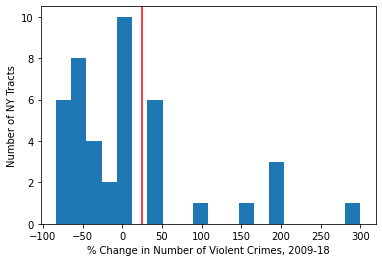

In [367]:
plt.hist(ny_gentrified_crime, bins=20);
plt.axvline(25, color='red');
plt.ylabel('Number of NY Tracts');
plt.xlabel('% Change in Number of Violent Crimes, 2009-18');

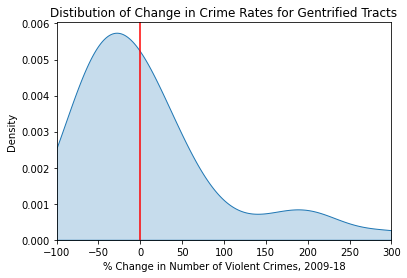

In [378]:
sns.kdeplot(data=ny_gentrified_crime, clip=(-100, 300), fill=True);
plt.axvline(0, color='red');
plt.xlabel('% Change in Number of Violent Crimes, 2009-18');
plt.xlim((-100, 300));
plt.title('Distibution of Change in Crime Rates for Gentrified Tracts')
plt.savefig('gentrified_change_in_crime.png');

In [186]:
num_crimes_by_tract_total

,2009,2018,pct_change
geoid,,,
36005000400,1,3,200.000000
36005001600,4,2,-50.000000
36005002000,3,6,100.000000
36005002500,2,5,150.000000
36005002800,2,4,100.000000
...,...,...,...
36085029104,4,1,-75.000000
36085030302,2,7,250.000000
36085031901,3,3,0.000000


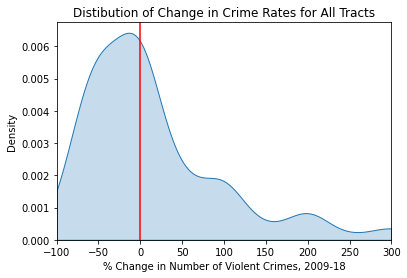

In [380]:
sns.kdeplot(data=num_crimes_by_tract_total['pct_change'], clip=(-100, 300), fill=True);
plt.axvline(0, color='red');
plt.xlabel('% Change in Number of Violent Crimes, 2009-18');
plt.xlim((-100, 300));
plt.title('Distibution of Change in Crime Rates for All Tracts')
plt.savefig('all_change_in_crime.png');

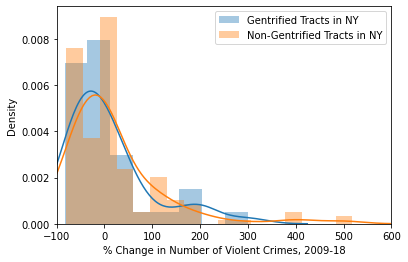

In [411]:
sns.distplot(ny_gentrified_crime, label='Gentrified Tracts in NY');
sns.distplot(ny_didnt_gentrify_crime, label='Non-Gentrified Tracts in NY');
plt.xlim((-100, 600));
plt.legend();
plt.xlabel('% Change in Number of Violent Crimes, 2009-18');
plt.savefig('gent_vs_nongent_change_in_crime.png');

In [176]:
gent_crime = [num_crimes_by_tract_total.loc[str(geoid), 'pct_change'] for geoid in kmeans_gent.index if str(geoid) in num_crimes_by_tract_total.index]

In [185]:
sum([True for geoid in kmeans_gent.index if str(geoid) in num_crimes_by_tract_total.index])

86

In [184]:
sum(gent_crime) / len(gent_crime)

18.582147826333873

In [209]:
num_crimes_by_tract_total['pct_change'].mean()

24.250001545828134

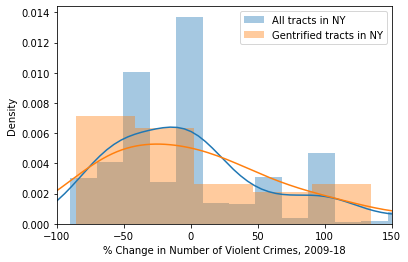

In [178]:
# kde=False, norm_hist=True

sns.distplot(num_crimes_by_tract_total['pct_change'],label='All tracts in NY');
sns.distplot(gent_crime, label='Gentrified tracts in NY');
plt.xlim((-100, 150));
plt.legend();
plt.xlabel('% Change in Number of Violent Crimes, 2009-18');
# plt.savefig('all_vs_gent_change_in_crime.png');

In [876]:
gent_bf.shape

(66, 52)

In [405]:
from scipy.stats import ks_2samp

In [204]:
ks_2samp(num_crimes_by_tract_total['pct_change'], gent_crime)

KstestResult(statistic=0.07262404286086813, pvalue=0.7687694118922689)

# Geo Visualization

In [886]:
ny_geo = pd.read_csv('nyct2010.csv', usecols=['the_geom', 'CT2010'])
ny_geo = ny_geo.set_index('CT2010')
ny_geo = ny_geo.drop_duplicates()

In [906]:
ny_geo.head()

,the_geom
CT2010,
900,MULTIPOLYGON (((-74.07920577013245 40.64343078...
9800,MULTIPOLYGON (((-73.96432543478758 40.75638153...
10000,MULTIPOLYGON (((-73.96802436915851 40.75957814...
10200,MULTIPOLYGON (((-73.97124277307127 40.76093641...
10400,MULTIPOLYGON (((-73.97445730550224 40.76229308...


In [896]:
kmeans_gent['tract'] = [int(str(geoid)[-6:]) for geoid in kmeans_gent.index]

In [909]:
kmeans_gent['geom'] = [ny_geo.loc[tract, 'the_geom'] if tract in ny_geo.index else None for tract in kmeans_gent.index]

In [914]:
sum([1 for geom in kmeans_gent.geom if geom == None])

130

In [24]:
# kmeans_gent.sort_values(by='geom')

In [224]:
num_crimes_by_tract_total['2009'].sum(), num_crimes_by_tract_total['2018'].sum()

(3053, 2912)

In [227]:
(num_crimes_by_tract_total['2018'].sum() / num_crimes_by_tract_total['2009'].sum() - 1) * 100

-4.618408123157547

In [225]:
gentr_crime_df['2009'].sum(), gentr_crime_df['2018'].sum()

(295, 270)

In [234]:
cr = pd.DataFrame.from_dict({'All Tracts' : [3053, 2912], 'Gentrified Tracts' : [295, 270]}, orient='index')
cr.columns = ['2009', '2018']
cr

,2009,2018
All Tracts,3053,2912
Gentrified Tracts,295,270


<AxesSubplot:>

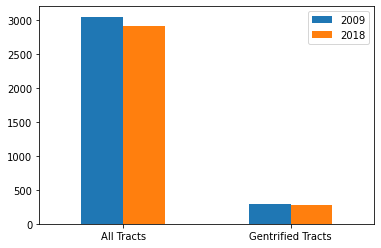

In [239]:
cr.plot.bar(rot=0)

In [228]:
(gentr_crime_df['2018'].sum() / gentr_crime_df['2009'].sum() - 1) * 100

-8.47457627118644

In [230]:
num_crimes_by_tract_total['2009'].sum() / num_crimes_by_tract_total.shape[0], num_crimes_by_tract_total['2018'].sum() / num_crimes_by_tract_total.shape[0]

(3.112130479102956, 2.9683995922528035)

In [231]:
gentr_crime_df['2009'].sum() / gentr_crime_df.shape[0], gentr_crime_df['2018'].sum() / gentr_crime_df.shape[0]

(3.4302325581395348, 3.13953488372093)

In [220]:
gentr_crime = [True if int(geoid) in kmeans_gent.index else False for geoid in num_crimes_by_tract_total.index]

In [222]:
gentr_crime_df = num_crimes_by_tract_total[gentr_crime]

In [223]:
gentr_crime_df 

,2009,2018,pct_change
geoid,,,
36005045101,1,1,0.000000
36047003500,7,8,14.285714
36047003900,1,1,0.000000
36047005900,5,6,20.000000
36047008000,3,1,-66.666667
...,...,...,...
36081007100,5,2,-60.000000
36081007500,1,2,100.000000
36081011600,2,1,-50.000000
